In [4]:
import librosa
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder

In [5]:
dataset_path = '/Users/hongtan/Downloads/archive/audio_speech_actors_01-24'
input_file = '/Users/hongtan/Downloads/inside_out_clip.mp4'
output_srt_file = "/Users/hongtan/Desktop/sentimentsub/website/sentsub/media/captions/audio.srt"
output_wav_file = "/Users/hongtan/Downloads/output.wav"
output_folder = "/Users/hongtan/Desktop/segmented-audio/"
insane_input_file = '/Users/hongtan/Desktop/sentimentsub/speech-to-text/audio-test-files/insane.wav'

In [6]:
# Function to extract features from each audio file
def extract_features(file_path):
    audio, sampling_rate = librosa.load(file_path, sr=22050, duration=None)
#     mfccs = librosa.feature.mfcc(y=audio, sr=sampling_rate, n_mfcc=30)
#     features = np.mean(mfccs.T, axis=0)
#     features=np.mean(librosa.feature.melspectrogram(y=audio, sr=sampling_rate).T,axis=0)
    
    features=np.array([])
    
    stft=np.abs(librosa.stft(audio))
    
    mfccs=np.mean(librosa.feature.mfcc(y=audio, sr=sampling_rate, n_mfcc=30).T, axis=0)

    chroma=np.mean(librosa.feature.chroma_stft(S=stft, sr=sampling_rate).T,axis=0)

    mel=np.mean(librosa.feature.melspectrogram(y=audio, sr=sampling_rate).T,axis=0)
    
    features=np.hstack((mfccs, chroma, mel))
    
    return features

# Function to preprocess the data
def preprocess_data(dataset_path):
    X = []
    y = []
    for folder in os.listdir(dataset_path):
        for file in os.listdir(os.path.join(dataset_path, folder)):
            if file.endswith('.wav'):
                
                emotion = file.split('-')[2]
                if int(emotion) == 1:
                    label = 'Neutral'
                elif int(emotion) == 2:
                    label = 'Neutral' # Calm
                elif int(emotion) == 3:
                    label = 'Happy'
                elif int(emotion) == 4:
                    label = 'Sad'
                elif int(emotion) == 5:
                    label = 'Angry'
                elif int(emotion) == 6:
                    label = 'Fearful'
                elif int(emotion) == 7:
                    label = 'Disgust'
                elif int(emotion) == 8:
                    label = 'Surprised'
                else:
                    label = 'UNK'
                    
                file_path = os.path.join(dataset_path, folder, file)
                features = extract_features(file_path)
                X.append(features)
                y.append(label)
    return np.array(X), np.array(y)

In [4]:
# Preprocess the data
X, y = preprocess_data(dataset_path)

# Print the shape of the feature matrix and the label array
print("Shape of X:", X.shape)
print("Shape of y:", y.shape)

Shape of X: (15840, 170)
Shape of y: (15840,)


In [5]:
# One-Hot encode y
OHE = OneHotEncoder()

y = np.array(y).reshape(-1,1)
y = OHE.fit_transform(y).toarray()

In [6]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=29, test_size=0.20, shuffle=True)

print('X_train: {}'.format(X_train.shape))
print('y_train: {}'.format(y_train.shape))
print('X_test: {}'.format(X_test.shape))
print('y_test: {}'.format(y_test.shape))

X_train: (12672, 170)
y_train: (12672, 7)
X_test: (3168, 170)
y_test: (3168, 7)


In [7]:
# Normalize data
SS = StandardScaler()

X_train = SS.fit_transform(X_train)
X_test = SS.transform(X_test)

print('X_train: {}'.format(X_train.shape))
print('y_train: {}'.format(y_train.shape))
print('X_test: {}'.format(X_test.shape))
print('y_test: {}'.format(y_test.shape))

X_train: (12672, 170)
y_train: (12672, 7)
X_test: (3168, 170)
y_test: (3168, 7)


In [8]:
X_train = np.expand_dims(X_train, axis=2)
X_test = np.expand_dims(X_test, axis=2)

print('X_train: {}'.format(X_train.shape))
print('X_test: {}'.format(X_test.shape))

X_train: (12672, 170, 1)
X_test: (3168, 170, 1)


In [11]:
# Function to plot Training Accuracy vs Validation Accuracy
def TrainVal_plot(history):
    val_acc = history.history['val_accuracy']
    train_acc = history.history['accuracy']

    epochs = range(0, 100)
    plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
    plt.plot(epochs, train_acc, 'r', label='Training Accuracy')
    plt.title('Training vs. Validation')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

In [8]:
# Import necessary libraries
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam

# Define input shape
input_shape = (170, 1)

# Create model
model = Sequential()

model.add(Conv1D(filters=8, kernel_size=3, activation='relu', input_shape=input_shape ,use_bias=False))
model.add(BatchNormalization())
model.add(MaxPooling1D())

model.add(Conv1D(filters=16, kernel_size=3, activation='relu', use_bias=False))
model.add(BatchNormalization())
model.add(MaxPooling1D())

model.add(Conv1D(filters=32, kernel_size=3, activation='relu', use_bias=False))
model.add(BatchNormalization())
model.add(MaxPooling1D())

model.add(Flatten())

model.add(Dense(units=128, activation='relu', use_bias=False))
model.add(BatchNormalization())

model.add(Dropout(0.5))

model.add(Dense(units=7, activation='softmax'))

# adam = Adam(learning_rate=0.01)
# Compile model with appropriate loss function, optimizer and metrics
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Print model summary
model.summary()

Metal device set to: Apple M1 Pro
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 168, 8)            24        
                                                                 
 batch_normalization (BatchN  (None, 168, 8)           32        
 ormalization)                                                   
                                                                 
 max_pooling1d (MaxPooling1D  (None, 84, 8)            0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 82, 16)            384       
                                                                 
 batch_normalization_1 (Batc  (None, 82, 16)           64        
 hNormalization)                                                 
                      

In [80]:
history = model.fit(X_train, y_train, batch_size=32, epochs=100, validation_data=(X_test, y_test),)

Epoch 1/100
396/396 [==============================] - 6s 14ms/step - loss: 1.8599 - accuracy: 0.3349 - val_loss: 1.6775 - val_accuracy: 0.3617
Epoch 2/100
396/396 [==============================] - 5s 14ms/step - loss: 1.5454 - accuracy: 0.4173 - val_loss: 1.4546 - val_accuracy: 0.4599
Epoch 3/100
396/396 [==============================] - 6s 14ms/step - loss: 1.4403 - accuracy: 0.4606 - val_loss: 1.3529 - val_accuracy: 0.4848
Epoch 4/100
396/396 [==============================] - 6s 14ms/step - loss: 1.3740 - accuracy: 0.4851 - val_loss: 1.4533 - val_accuracy: 0.4650
Epoch 5/100
396/396 [==============================] - 6s 14ms/step - loss: 1.3278 - accuracy: 0.5066 - val_loss: 1.2809 - val_accuracy: 0.5246
Epoch 6/100
396/396 [==============================] - 5s 14ms/step - loss: 1.2828 - accuracy: 0.5275 - val_loss: 1.2637 - val_accuracy: 0.5328
Epoch 7/100
396/396 [==============================] - 6s 14ms/step - loss: 1.2381 - accuracy: 0.5439 - val_loss: 1.2537 - val_accuracy:

In [81]:
print("Accuracy of our model on Train data : " , round(model.evaluate(X_train,y_train)[1]*100,2) , "%")

396/396 [==============================] - 3s 6ms/step - loss: 0.4715 - accuracy: 0.8582
Accuracy of our model on Train data :  85.82 %


In [82]:
print("Accuracy of our model on test data : " , round(model.evaluate(X_test,y_test)[1]*100,2) , "%")

99/99 [==============================] - 1s 6ms/step - loss: 0.9891 - accuracy: 0.6651
Accuracy of our model on test data :  66.51 %


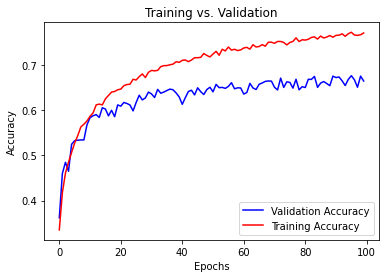

In [83]:
TrainVal_plot(history)

In [9]:
emotions = ['Angry', 'Disgust', 'Fearful', 'Happy', 'Neutral', 'Sad', 'Surprised']

In [37]:
from transformers import pipeline
classifier = pipeline("text-classification", model="j-hartmann/emotion-english-distilroberta-base", max_length=512)

0 --> Angry
1 --> Disgust
2 --> Fearful
3 --> Happy
4 --> Neutral
5 --> Sad
6 --> Surprised

In [95]:
# Read and classify each line of dialogue
with open(output_srt_file, 'r') as f:
    lines = f.readlines()
    n = len(lines)
    text_probs = []
    for i in range(2,n,4):
        text_clas = classifier(lines[i])[0]
        text_prob = []
        for i in range(7):
            prob = text_clas[i]['score']
            text_prob.append(prob)
        text_prob = np.array(text_prob)
        text_probs.append(text_prob)
    text_probs = np.array(text_probs)

In [36]:
# Running model on files
for i in range(129):
    audio_file = f'/Users/hongtan/Desktop/sentimentsub/website/sentsub/media/segmented_wavs/{i}.wav'
    audio_features = extract_features(audio_file)
    audio_features = np.expand_dims(audio_features, axis=1)
    test = np.array([audio_features])
    prediction = model.predict(test)
    print(i, emotions[np.argmax(prediction)])

1/1 [==============================] - 0s 37ms/step
0 Happy
1/1 [==============================] - 0s 25ms/step
1 Happy
1/1 [==============================] - 0s 43ms/step
2 Happy
1/1 [==============================] - 0s 28ms/step
3 Happy
1/1 [==============================] - 0s 21ms/step
4 Happy
1/1 [==============================] - 0s 43ms/step
5 Happy
1/1 [==============================] - 0s 53ms/step
6 Happy
1/1 [==============================] - 0s 25ms/step
7 Happy
1/1 [==============================] - 0s 49ms/step
8 Happy
1/1 [==============================] - 0s 63ms/step
9 Happy
1/1 [==============================] - 0s 36ms/step
10 Happy
1/1 [==============================] - 0s 33ms/step
11 Happy
1/1 [==============================] - 0s 21ms/step
12 Happy
1/1 [==============================] - 0s 26ms/step
13 Happy
1/1 [==============================] - 0s 20ms/step
14 Happy
1/1 [==============================] - 0s 22ms/step
15 Happy
1/1 [=============================

In [47]:
# Read and classify each line of dialogue
with open('/Users/hongtan/Desktop/sentimentsub/website/sentsub/media/captions/audio.srt', 'r') as f:
    lines = f.readlines()
    n = len(lines)
    for i in range(2,n,4):
#         print(lines[i])
        print(classifier(lines[i])[0]['label'])

neutral
surprise
disgust
neutral
disgust
neutral
neutral
disgust
disgust
surprise
surprise
neutral
neutral
neutral
neutral
joy
anger
disgust
surprise
neutral
joy
neutral
neutral
neutral
surprise
neutral
fear
fear
neutral
joy
neutral
joy
surprise
surprise
surprise
disgust
neutral
neutral
sadness
fear
neutral
neutral
neutral
neutral
fear
disgust
neutral
neutral
surprise
neutral
neutral
neutral
surprise
neutral
neutral
neutral
disgust
fear
neutral
neutral
disgust
neutral
disgust
neutral
surprise
neutral
sadness
anger
disgust
disgust
surprise
neutral
surprise
anger
fear
neutral
neutral
neutral
neutral
sadness
sadness
neutral
sadness
surprise
joy
joy
neutral
neutral
neutral
neutral
disgust
neutral
neutral
anger
sadness
neutral
neutral
disgust
neutral
neutral
fear
joy
neutral
neutral
disgust
neutral
surprise
neutral
disgust
anger
anger
neutral
neutral
neutral
neutral
neutral
neutral
anger
anger
neutral
neutral
neutral
neutral
neutral
neutral
fear
disgust
neutral
neutral


In [98]:
prob = (text_probs[1] + prediction / 5) / (text_probs[1] + prediction / 5).sum()
prob

array([[0.00238788, 0.00560303, 0.00209024, 0.00354253, 0.03622993,
        0.94206543, 0.00808095]])

In [78]:
emotions[np.argmax(prob)]

'Disgust'

In [ ]:
# Get SRT file
import stable_whisper
whisper_model = stable_whisper.load_model('base')
result = whisper_model.transcribe(insane_input_file, fp16=False)
result.to_srt_vtt(output_srt_file, word_level=False)

In [ ]:
# Segment mp4 file into multiple wav files according to SRT file
from pydub import AudioSegment
import os

# Load audio file
# sound = AudioSegment.from_file(input_file, format="mp4")
# sound = sound.set_channels(1)
# sound.export(output_wav_file, format="wav")
audio = AudioSegment.from_wav(insane_input_file)

# Parse SRT file
with open(output_srt_file, "r") as f:
    lines = f.readlines()
    subtitles = []
    for line in lines:
        if "-->" in line:
            start, end = line.strip().split(" --> ")
            start = start.split(":")
            end = end.split(":")
            start = int(start[0]) * 3600 + int(start[1]) * 60 + float(start[2].replace(",", "."))
            end = int(end[0]) * 3600 + int(end[1]) * 60 + float(end[2].replace(",", "."))
            subtitles.append((start * 1000, end * 1000))

# Create output directory
os.makedirs(output_folder, exist_ok=True)

# Split audio file and export segments
for i, (start, end) in enumerate(subtitles):
    segment = audio[start:end]
    segment.export(output_folder + str(i) + ".wav", format="wav")

In [86]:
model.save_weights('/Users/hongtan/Desktop/sentimentsub/final_model/')

In [11]:
model.load_weights('/Users/hongtan/Desktop/sentimentsub/final_model/')

In [13]:
print("Accuracy of our model on Train data : " , round(model.evaluate(X_train,y_train)[1]*100,2) , "%")

NameError: name 'X_train' is not defined

In [14]:
print("Accuracy of our model on test data : " , round(model3.evaluate(X_test,y_test)[1]*100,2) , "%")

NameError: name 'model3' is not defined

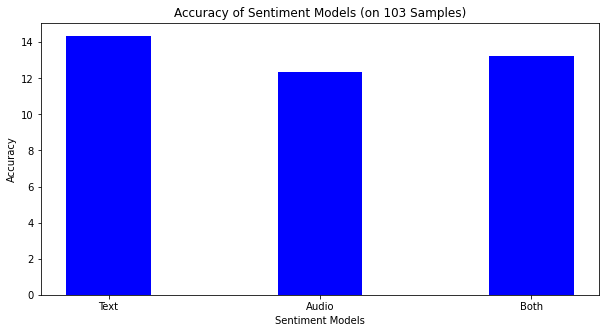

In [57]:
import numpy as np
import matplotlib.pyplot as plt
 
  
# creating the dataset
data = {'Text':14.35, 'Audio':12.34, 'Both':13.23,}
courses = list(data.keys())
values = list(data.values())
  
fig = plt.figure(figsize = (10, 5))
 
# creating the bar plot
plt.bar(courses, values, color ='blue', width = 0.4)
 
plt.xlabel("Sentiment Models")
plt.ylabel("Accuracy")
plt.title("Accuracy of Sentiment Models (on 103 Samples)")
plt.show()

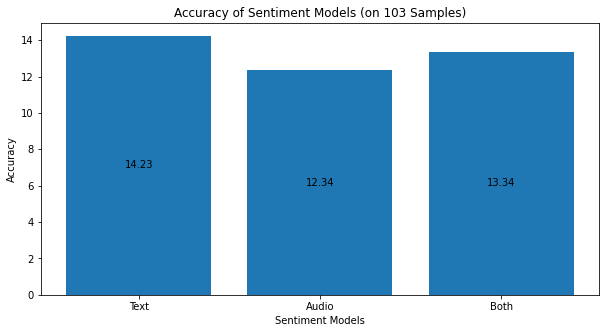

In [60]:
# function to add value labels
def addlabels(x,y):
    for i in range(len(x)):
        plt.text(i, y[i]//2, y[i], ha = 'center')
 
   
# creating data on which bar chart will be plot
x = ["Text", "Audio", "Both"]

y = [14.23, 12.34, 13.34]

# setting figure size by using figure() function
plt.figure(figsize = (10,5))

# making the bar chart on the data
plt.bar(x, y)

# calling the function to add value labels
addlabels(x, y)

# giving title to the plot
plt.title("Accuracy of Sentiment Models (on 103 Samples)")

# giving X and Y labels
plt.xlabel("Sentiment Models")
plt.ylabel("Accuracy")

# visualizing the plot
plt.show()

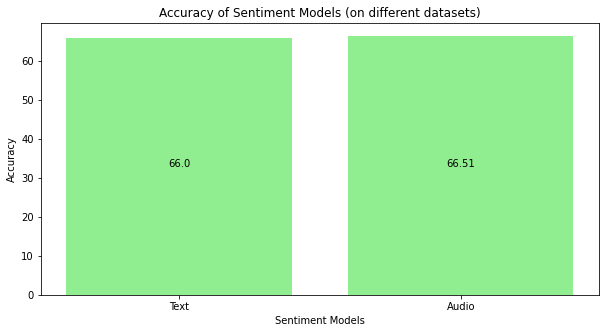

In [68]:
# function to add value labels
def addlabels(x,y):
    for i in range(len(x)):
        plt.text(i, y[i]//2, y[i], ha = 'center')
 
   
# creating data on which bar chart will be plot
x = ["Text", "Audio"]

y = [66.0, 66.51]

# setting figure size by using figure() function
plt.figure(figsize = (10,5))

# making the bar chart on the data
plt.bar(x, y, color ='lightgreen')

# calling the function to add value labels
addlabels(x, y)

# giving title to the plot
plt.title("Accuracy of Sentiment Models (on different datasets)")

# giving X and Y labels
plt.xlabel("Sentiment Models")
plt.ylabel("Accuracy")

# visualizing the plot
plt.show()